# Roteiro Completo de Aprendizado de Máquina com Dados Tabulares (Heart Dataset)


O notebook apresenta um **pipeline completo de Machine Learning**, cobrindo desde a análise inicial dos dados até a avaliação final de modelos de **classificação** e **regressão**.


### Objetivos principais:
- Compreender a estrutura do conjunto de dados
- Preparar os dados corretamente para modelagem
- Treinar e comparar **vários modelos de Machine Learning**
- Avaliar os modelos com métricas adequadas
- Aplicar técnicas de **explicabilidade (feature importance)**


### Tarefas abordadas:
- Classificação (prever presença de doença cardíaca)
- Regressão (prever um valor contínuo a partir das features)


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report,
    mean_squared_error, r2_score
)

# Modelos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelos de regressão
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
pd.set_option('display.max_columns', 100)

## 1) Carregar e inspecionar os dados


Antes de qualquer modelagem, é essencial entender os dados disponíveis.


Nesta etapa temos:
- Carregar o conjunto de dados
- Visualizar as primeiras linhas
- Verificar o número de amostras (linhas) e atributos (colunas)


Isso ajuda a identificar possíveis problemas iniciais, como:
- Dados faltantes
- Tipos incorretos de variáveis
- Colunas que precisarão de pré-processamento

In [19]:
df = pd.read_csv('../data/heart.csv')
display(df.head())
print('Shape:', df.shape)
print('\nTipos de coluna:')
display(df.dtypes)

print('\nValores faltantes por coluna:')
display(df.isna().sum().sort_values(ascending=False))

print('\nDistribuição do alvo (target):')
display(df['target'].value_counts())
display(df['target'].value_counts(normalize=True).rename('proporção'))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Shape: (1025, 14)

Tipos de coluna:


age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


Valores faltantes por coluna:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Distribuição do alvo (target):


target
1    526
0    499
Name: count, dtype: int64

target
1    0.513171
0    0.486829
Name: proporção, dtype: float64

## 2) Separar X (features) e y (alvo)


Em problemas de **aprendizado supervisionado**, separamos:
- **X** → variáveis explicativas (features)
- **y** → variável alvo (o que queremos prever)


Neste caso:
- O alvo é a coluna `target`
- O problema é de **classificação binária**:
- `0` → ausência de doença cardíaca
- `1` → presença de doença cardíaca


Essa separação é fundamental para treinar corretamente os modelos.

In [20]:
X = df.drop(columns=['target'])
y = df['target']
print('X:', X.shape, 'y:', y.shape)

X: (1025, 13) y: (1025,)


## 3) Dividir os dados em treino e teste


Para avaliar se o modelo generaliza bem para dados novos, dividimos o conjunto em:
- **Treino**: usado para ajustar o modelo
- **Teste**: usado apenas para avaliação final


Boas práticas adotadas aqui:
- Uso de `test_size` para controlar o tamanho do conjunto de teste
- Uso de `random_state` para reprodutibilidade
- Uso de `stratify=y` para manter a proporção das classes

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
print('Treino:', X_train.shape, 'Teste:', X_test.shape)
print('Proporção classes no treino:')
display(y_train.value_counts(normalize=True))
print('Proporção classes no teste:')
display(y_test.value_counts(normalize=True))

Treino: (820, 13) Teste: (205, 13)
Proporção classes no treino:


target
1    0.513415
0    0.486585
Name: proportion, dtype: float64

Proporção classes no teste:


target
1    0.512195
0    0.487805
Name: proportion, dtype: float64

## 4) Pré-processamento dos dados

Dados reais quase nunca estão prontos para serem utilizados diretamente por modelos
de Machine Learning. Por isso, nesta etapa construímos um **pipeline completo de
pré-processamento**, garantindo que cada tipo de variável receba o tratamento adequado.

### Estratégia adotada

As variáveis foram **explicitamente separadas** em dois grupos:
- **Numéricas**: variáveis contínuas ou ordinais
- **Categóricas**: variáveis discretas que representam categorias

Essa separação manual é especialmente importante neste dataset, pois algumas variáveis
são representadas por números, mas possuem **natureza categórica** (ex.: `sex`, `cp`, `thal`).

### Tratamento das variáveis numéricas
Para as variáveis numéricas, aplicamos:
- **Imputação de valores faltantes** usando a mediana
- **Padronização (StandardScaler)** para colocar todas na mesma escala

### Tratamento das variáveis categóricas
Para as variáveis categóricas, aplicamos:
- **Imputação de valores faltantes** usando a moda
- **One-Hot Encoding**, permitindo que modelos matemáticos lidem corretamente com categorias
- Uso de `handle_unknown='ignore'` para evitar erros com categorias não vistas no treino

### Integração com ColumnTransformer
Utilizamos o **ColumnTransformer** para:
- Aplicar automaticamente o pipeline correto a cada tipo de variável
- Garantir que o pré-processamento seja executado corretamente dentro da validação cruzada
- Descartar colunas não listadas (`remainder='drop'`), evitando comportamentos inesperados

### Vantagens dessa abordagem
- Evita **vazamento de dados (data leakage)**
- Garante consistência entre treino, validação e teste
- Facilita o uso de **Grid Search** e **Cross-Validation**
- Deixa o código mais organizado, modular e reutilizável


In [22]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

# 1) Definição MANUAL 
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# 2) Pipelines de tratamento
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3) Junta tudo (cada tipo recebe o tratamento correto)
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='drop'  # descarta qualquer coluna não listada (evita surpresa)
)
preprocess

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [23]:
X_train_pp = preprocess.fit_transform(X_train)
print(X_train_pp.shape)

(820, 30)


## 5) Definição e comparação dos modelos de classificação

Nesta etapa definimos e comparamos **múltiplos algoritmos de classificação** utilizando
uma abordagem **padronizada e justa**, baseada em validação cruzada e otimização de
hiperparâmetros.

Em vez de treinar cada modelo manualmente, usamos uma **função genérica**
que aplica exatamente o mesmo pipeline de pré-processamento, validação e avaliação
para todos os algoritmos.

### Modelos avaliados
Os seguintes modelos de classificação são testados:
- **Regressão Logística** – modelo linear e interpretável
- **KNN (K-Nearest Neighbors)** – modelo baseado em proximidade entre amostras
- **SVM (Support Vector Machine)** – modelo de margem máxima
- **Árvore de Decisão** – modelo não linear e interpretável
- **Random Forest** – conjunto de árvores (ensemble)
- **Gradient Boosting** – ensemble sequencial focado em reduzir erros

Essa diversidade permite comparar modelos:
- Lineares vs. não lineares  
- Simples vs. ensembles  
- Baseados em distância, margens ou árvores  

### Estratégia de avaliação
Para garantir uma comparação justa entre os modelos, adotamos:

- **StratifiedKFold (k=5)**  
  Mantém a proporção das classes em cada dobra da validação cruzada.

- **Pipeline (pré-processamento + modelo)**  
  Garante que todo o pré-processamento seja aplicado corretamente dentro da validação,
  evitando vazamento de dados (*data leakage*).

- **GridSearchCV**  
  Testa automaticamente diferentes combinações de hiperparâmetros para cada modelo.

- **Múltiplas métricas de avaliação**  
  Avaliamos simultaneamente:
  - accuracy
  - precision
  - recall
  - f1

### Critério de seleção do melhor modelo
Embora várias métricas sejam calculadas, o melhor modelo é escolhido com base no
**F1-score** (`refit='f1'`), pois essa métrica equilibra *precision* e *recall* e é
mais robusta quando há desbalanceamento ou custos diferentes entre erros.

### Organização dos resultados
Para cada modelo testado, armazenamos:
- Melhor F1 médio na validação cruzada
- Melhores hiperparâmetros encontrados
- Pipeline final treinado com esses hiperparâmetros
- Resultados completos da validação cruzada

Esses resultados são salvos em uma lista (`results_cls`) para posterior análise e comparação.


In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

def run_grid(name, estimator, param_grid):
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', estimator)])
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit='f1',  # escolhe o melhor pelo F1
        n_jobs=-1,
        return_train_score=False
    )
    grid.fit(X_train, y_train)
    return {
        'model_name': name,
        'best_f1_cv': grid.best_score_,
        'best_params': grid.best_params_,
        'best_estimator': grid.best_estimator_,
        'cv_results': grid.cv_results_
    }

results_cls = []

## 5.1) Espaço de busca de hiperparâmetros (Classificação)

Após definir a estratégia de validação e avaliação, especificamos agora
**quais modelos serão treinados** e **quais hiperparâmetros serão explorados**
pelo GridSearchCV.

Cada modelo é definido juntamente com um **conjunto de hiperparâmetros relevantes**,
permitindo que o processo de validação cruzada encontre automaticamente a melhor
configuração para cada algoritmo.

A estrutura utilizada é uma lista de tuplas contendo:
1. Nome do modelo (para identificação)
2. Estimador do scikit-learn
3. Grade de hiperparâmetros (`param_grid`)

### Modelos e hiperparâmetros avaliados

#### Regressão Logística
- Modelo linear amplamente utilizado como baseline
- `C`: controla a força da regularização
- `penalty='l2'`: regularização padrão
- `class_weight`: permite compensar possíveis desbalanceamentos de classe

#### SVM com kernel RBF
- Modelo não linear baseado em margens máximas
- `C`: controla o trade-off entre margem larga e erro
- `gamma`: define o alcance da influência de cada amostra
- `class_weight`: ajuste para possíveis desbalanceamentos

#### K-Nearest Neighbors (KNN)
- Modelo baseado em distância entre amostras
- `n_neighbors`: número de vizinhos considerados
- `weights`: ponderação uniforme ou por distância
- `p`: métrica de distância (Manhattan ou Euclidiana)

#### Naive Bayes Gaussiano
- Modelo probabilístico simples e rápido
- Poucos hiperparâmetros ajustáveis
- `var_smoothing`: melhora a estabilidade numérica

#### Random Forest
- Ensemble de árvores de decisão
- `n_estimators`: número de árvores
- `max_depth`: profundidade máxima das árvores
- `min_samples_split`: mínimo de amostras para divisão
- `class_weight`: tratamento de desbalanceamento

#### Gradient Boosting
- Ensemble sequencial focado em reduzir erros anteriores
- `n_estimators`: número de árvores
- `learning_rate`: taxa de aprendizado
- `max_depth`: complexidade das árvores base

### Observações importantes
- Todos os hiperparâmetros usam o prefixo `model__` pois o estimador está
  encapsulado em um **Pipeline**.
- As grades foram mantidas **moderadas**, equilibrando qualidade do ajuste
  e custo computacional.
- Essa abordagem garante uma **comparação justa**, já que todos os modelos
  passam pelo mesmo processo de pré-processamento, validação cruzada e seleção.

Ao final, cada modelo será avaliado com base no **F1-score médio em validação cruzada**,
permitindo escolher a abordagem mais adequada para o problema.


In [25]:
models_and_grids = [
    (
        'LogisticRegression',
        LogisticRegression(max_iter=5000, random_state=RANDOM_STATE),
        {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l2'],
            'model__class_weight': [None, 'balanced'],
            'model__solver': ['lbfgs']
        }
    ),
    (
        'SVC_RBF',
        SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE),
        {
            'model__C': [0.5, 1.0, 5.0],
            'model__gamma': ['scale', 0.1, 0.01],
            'model__class_weight': [None, 'balanced']
        }
    ),
    (
        'KNN',
        KNeighborsClassifier(),
        {
            'model__n_neighbors': [3, 5, 11, 21],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]  # 1=Manhattan, 2=Euclidean
        }
    ),
    (
        'GaussianNB',
        GaussianNB(),
        {
            # Não tem muitos hiperparâmetros; ainda assim testamos var_smoothing
            'model__var_smoothing': [1e-09, 1e-08, 1e-07]
        }
    ),
    (
        'RandomForest',
        RandomForestClassifier(random_state=RANDOM_STATE),
        {
            'model__n_estimators': [200, 500],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 10],
            'model__class_weight': [None, 'balanced']
        }
    ),
    (
        'GradientBoosting',
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {
            'model__n_estimators': [100, 300],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [2, 3]
        }
    )
]

len(models_and_grids)

6

## 5.2) Execução do Grid Search e comparação final dos modelos

Nesta etapa executamos efetivamente o **GridSearchCV para todos os modelos definidos**,
utilizando a mesma estratégia de pré-processamento, validação cruzada e avaliação.

Cada modelo é treinado e avaliado de forma **independente**, mas seguindo exatamente
o mesmo protocolo, garantindo uma comparação justa.

### Execução dos experimentos
Para cada modelo presente em `models_and_grids`:
- Aplicamos o pipeline completo (pré-processamento + modelo)
- Executamos o Grid Search com validação cruzada estratificada
- Selecionamos automaticamente a melhor configuração com base no **F1-score**
- Armazenamos os resultados relevantes em uma lista (`results_cls`)

Esse processo pode levar alguns minutos, pois envolve múltiplos treinos por modelo.

### Organização dos resultados
Após a execução de todos os experimentos, consolidamos os resultados em uma tabela
resumo contendo:
- Nome do modelo
- Melhor **F1-score médio** obtido na validação cruzada
- Conjunto de **hiperparâmetros ótimos** encontrados pelo Grid Search

A tabela é então **ordenada do maior para o menor F1-score**, facilitando a identificação
do modelo com melhor desempenho médio durante a validação cruzada.

### Interpretação
O modelo no topo da tabela representa aquele que, em média:
- Obteve o melhor equilíbrio entre *precision* e *recall*
- Apresentou maior robustez ao longo das dobras da validação cruzada

Esse modelo será utilizado nas próximas etapas para:
- Avaliação final no conjunto de teste
- Análises adicionais, como matriz de confusão e explicabilidade


In [26]:
for name, model, grid in models_and_grids:
    print(f'Rodando: {name} ...')
    res = run_grid(name, model, grid)
    results_cls.append(res)
print('Concluído!')

# Tabela resumo (ordenada pelo melhor F1 médio na validação cruzada)
summary_cls = pd.DataFrame([
    {
        'modelo': r['model_name'],
        'f1_cv': r['best_f1_cv'],
        'melhores_hiperparametros': r['best_params']
    }
    for r in results_cls
]).sort_values('f1_cv', ascending=False)

display(summary_cls)

Rodando: LogisticRegression ...
Rodando: SVC_RBF ...
Rodando: KNN ...
Rodando: GaussianNB ...
Rodando: RandomForest ...
Rodando: GradientBoosting ...
Concluído!


,modelo,f1_cv,melhores_hiperparametros
2,KNN,0.990445,"{'model__n_neighbors': 21, 'model__p': 1, 'mod..."
4,RandomForest,0.984505,"{'model__class_weight': None, 'model__max_dept..."
5,GradientBoosting,0.982014,"{'model__learning_rate': 0.1, 'model__max_dept..."
1,SVC_RBF,0.966571,"{'model__C': 5.0, 'model__class_weight': None,..."
0,LogisticRegression,0.879404,"{'model__C': 10.0, 'model__class_weight': None..."
3,GaussianNB,0.835802,{'model__var_smoothing': 1e-07}


## 6) Seleção do melhor modelo e avaliação final no conjunto de teste

Após a execução do Grid Search e da validação cruzada, selecionamos agora
o **melhor modelo de classificação**, com base no **F1-score médio** obtido
durante a validação cruzada.

Essa etapa simula um cenário real de uso, avaliando o desempenho do modelo
em **dados nunca vistos durante o treinamento**.

### Seleção do melhor modelo
- Identificamos o modelo com maior F1 médio na validação cruzada
- Recuperamos o **pipeline completo** (pré-processamento + modelo)
  já treinado com os melhores hiperparâmetros
- Não é necessário re-treinar manualmente, pois o `GridSearchCV`
  já devolve o `best_estimator_` ajustado

### Avaliação no conjunto de teste
O modelo selecionado é avaliado no conjunto de teste usando as seguintes métricas:

- **Accuracy**: proporção total de acertos
- **Precision**: qualidade das previsões positivas
- **Recall**: capacidade de detectar a classe positiva
- **F1-score**: equilíbrio entre precision e recall

Além disso, apresentamos:
- **Classification Report**, com métricas por classe
- **Matriz de confusão**, para visualizar erros e acertos do modelo

### Interpretação
Essa avaliação final é a estimativa mais próxima do desempenho real do modelo
em produção, pois utiliza dados que **não participaram nem do treinamento
nem da validação cruzada**.

Os resultados obtidos aqui são usados como base para:
- Comparação com outros modelos
- Discussões sobre desempenho e limitações
- Etapas posteriores de explicabilidade


Melhor modelo (por F1-CV): KNN
Melhores hiperparâmetros:


{'model__n_neighbors': 21, 'model__p': 1, 'model__weights': 'distance'}

ACC=1.000 | PREC=1.000 | REC=1.000 | F1=1.000

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



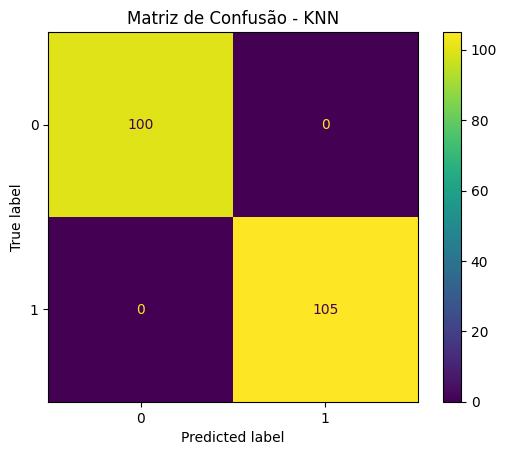

In [27]:
best_row = summary_cls.iloc[0]
best_model_name = best_row['modelo']
best_entry = next(r for r in results_cls if r['model_name'] == best_model_name)
best_pipe = best_entry['best_estimator']

print('Melhor modelo (por F1-CV):', best_model_name)
print('Melhores hiperparâmetros:')
display(best_entry['best_params'])

# Treina no treino completo (GridSearchCV já devolve o best_estimator treinado)
y_pred = best_pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'ACC={acc:.3f} | PREC={prec:.3f} | REC={rec:.3f} | F1={f1:.3f}')
print('\nClassification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()

## 7) Bônus: Explicabilidade – Importância das variáveis

Além do desempenho preditivo, é fundamental entender **como o modelo toma decisões**.
Nesta etapa aplicamos uma técnica de explicabilidade baseada em **Permutation Importance**,
adequada para dados tabulares e compatível com qualquer tipo de modelo.

### Intuição do método
A ideia é simples:
- Embaralhamos os valores de uma variável, quebrando sua relação com o alvo
- Medimos o quanto a métrica de interesse (F1-score) piora
- Quanto maior a queda, mais importante é a variável para o modelo

### Por que usar Permutation Importance?
- Método **agnóstico ao modelo**
- Mede impacto direto na **métrica final**
- Pode ser aplicado em dados de teste, evitando viés otimista
- Fácil de interpretar e comunicar

### Interpretação
As variáveis com maior queda média no F1 são aquelas que mais influenciam
as decisões do modelo. Variáveis com impacto próximo de zero têm pouca
ou nenhuma contribuição preditiva.


ca          0.092023
thal        0.069175
cp          0.066552
slope       0.062337
sex         0.055315
trestbps    0.055060
thalach     0.053161
age         0.052902
restecg     0.048247
exang       0.046653
chol        0.043043
oldpeak     0.037329
fbs         0.017912
dtype: float64

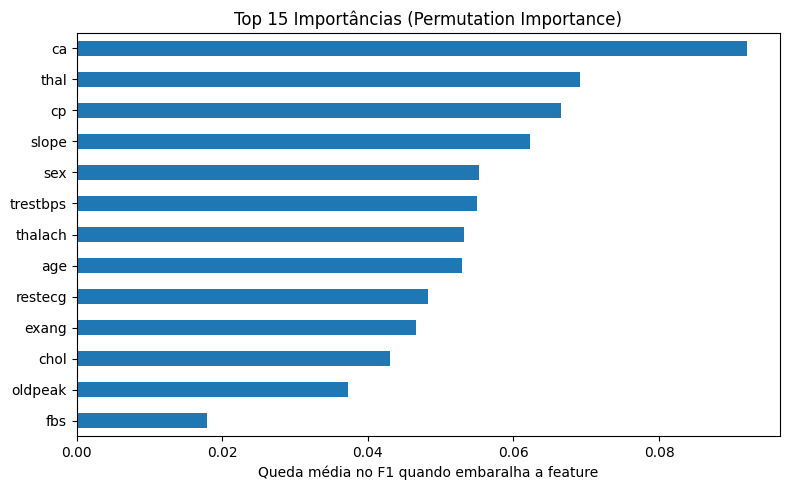

In [28]:
best_pipe.fit(X_train, y_train)

perm = permutation_importance(
    best_pipe,
    X_test,
    y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring='f1'
)

importances = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)

display(importances.head(15))

plt.figure(figsize=(8, 5))
importances.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Importâncias (Permutation Importance)')
plt.xlabel('Queda média no F1 quando embaralha a feature')
plt.tight_layout()
plt.show()


# Parte 2: Regressão (≥ 3 modelos)
Agora faremos um problema de regressão **usando o mesmo dataset**, apenas escolhendo um alvo contínuo.

### Qual variável vamos prever?
Vamos prever `chol` (colesterol), que é numérica.

**Por quê isso faz sentido?**
- Você treina o pipeline de regressão exigido pelo enunciado.
- Reaproveita o mesmo conjunto tabular.

### Métricas exigidas
- **R²**: quanto da variância do alvo o modelo explica.
- **RMSE**: erro médio quadrático na escala original (quanto menor, melhor).

Vamos comparar 3 modelos:
- Ridge (linear com regularização)
- RandomForestRegressor
- GradientBoostingRegressor

In [29]:
y_reg = df['chol']
X_reg = df.drop(columns=['chol', 'target'])  # remove colesterol e o alvo de classificação

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print('X_reg:', X_reg.shape, 'y_reg:', y_reg.shape)
print('Treino:', Xr_train.shape, 'Teste:', Xr_test.shape)

X_reg: (1025, 12) y_reg: (1025,)
Treino: (820, 12) Teste: (205, 12)


## 8) Pipeline de regressão e validação cruzada

Nesta etapa repetimos a mesma lógica adotada na classificação, agora aplicada
a um **problema de regressão**, no qual o objetivo é prever uma variável contínua.

Embora o fluxo geral seja semelhante, há diferenças importantes em relação:
- Às métricas utilizadas
- Ao critério de seleção do melhor modelo
- À interpretação dos resultados

### Pré-processamento dos dados
O pré-processamento segue a mesma estratégia da classificação:
- Variáveis numéricas:
  - Imputação de valores faltantes pela mediana
  - Padronização com `StandardScaler`
- Variáveis categóricas:
  - Imputação pela moda
  - Codificação com `OneHotEncoder`
- Uso de `ColumnTransformer` para aplicar cada tratamento corretamente
- Descarte de colunas não listadas (`remainder='drop'`)

Essa abordagem garante consistência e evita vazamento de dados durante a validação cruzada.

### Validação cruzada e otimização de hiperparâmetros
Utilizamos novamente o **GridSearchCV**, agora com foco em métricas de regressão.

As métricas avaliadas são:
- **RMSE (Root Mean Squared Error)**  
  Mede o erro médio do modelo, penalizando erros grandes
- **R² (coeficiente de determinação)**  
  Mede o quanto da variância do alvo é explicada pelo modelo

### Por que usar `neg_root_mean_squared_error`?
O scikit-learn sempre assume que **métricas maiores são melhores**.
Como o RMSE é um erro (quanto menor, melhor), o sklearn utiliza o valor negativo
do RMSE durante a otimização.

Por isso:
- Usamos `neg_root_mean_squared_error` no `scoring`
- Definimos `refit='rmse'` para escolher o modelo com menor erro
- Convertimos o valor negativo para RMSE positivo apenas para interpretação

### Organização dos resultados
Para cada modelo de regressão testado, armazenamos:
- Melhor RMSE médio na validação cruzada
- Melhor R² médio
- Melhores hiperparâmetros encontrados
- Pipeline final treinado com esses hiperparâmetros
- Resultados completos da validação cruzada

Esses resultados são armazenados em uma lista (`results_reg`) para posterior
comparação e análise.


In [30]:
numeric_features_reg = Xr_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_reg = [c for c in Xr_train.columns if c not in numeric_features_reg]

numeric_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_reg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_reg, numeric_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)
    ],
    remainder='drop'
)

cv_reg = 5
scoring_reg = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

def run_grid_reg(name, estimator, param_grid):
    pipe = Pipeline(steps=[('preprocess', preprocess_reg), ('model', estimator)])
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv_reg,
        scoring=scoring_reg,
        refit='rmse',
        n_jobs=-1,
        return_train_score=False
    )
    grid.fit(Xr_train, yr_train)
    return {
        'model_name': name,
        'best_neg_rmse_cv': grid.best_score_,
        'best_rmse_cv': -grid.best_score_,
        'best_params': grid.best_params_,
        'best_estimator': grid.best_estimator_,
        'cv_results': grid.cv_results_
    }

results_reg = []

### 8.1) Grades de hiperparâmetros dos modelos de regressão

Assim como na classificação, não é adequado comparar modelos utilizando
configurações arbitrárias ou padrões. Por isso, para cada algoritmo de
regressão definimos uma **grade de hiperparâmetros plausíveis**, permitindo
que o GridSearchCV encontre automaticamente a melhor configuração por
validação cruzada.

A escolha dos modelos contempla abordagens **lineares** e **não lineares**,
permitindo avaliar diferentes níveis de complexidade e capacidade de ajuste.

### Modelos avaliados

#### Ridge Regression
- Modelo linear com regularização L2
- Útil como baseline robusto contra multicolinearidade
- `alpha`: controla a força da regularização (valores maiores → modelo mais simples)

#### Random Forest Regressor
- Ensemble de árvores de decisão
- Captura relações não lineares entre as variáveis
- `n_estimators`: número de árvores no ensemble
- `max_depth`: profundidade máxima das árvores
- `min_samples_split`: mínimo de amostras para dividir um nó

#### Gradient Boosting Regressor
- Ensemble sequencial que corrige erros de modelos anteriores
- Geralmente apresenta bom desempenho em dados tabulares
- `n_estimators`: número de árvores
- `learning_rate`: taxa de aprendizado
- `max_depth`: complexidade das árvores base

### Observações importantes
- Todos os hiperparâmetros utilizam o prefixo `model__` pois os estimadores
  estão encapsulados em um **Pipeline**.
- As grades foram escolhidas para equilibrar **desempenho e custo computacional**.
- Essa abordagem garante uma comparação justa entre modelos, pois todos são
  avaliados sob a mesma estratégia de pré-processamento e validação cruzada.

Ao final, cada modelo será comparado com base no **RMSE médio** obtido na
validação cruzada.


In [31]:
models_and_grids_reg = [
    (
        'Ridge',
        Ridge(random_state=RANDOM_STATE),
        {
            'model__alpha': [0.1, 1.0, 10.0, 100.0]
        }
    ),
    (
        'RandomForestRegressor',
        RandomForestRegressor(random_state=RANDOM_STATE),
        {
            'model__n_estimators': [300, 800],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 10]
        }
    ),
    (
        'GradientBoostingRegressor',
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        {
            'model__n_estimators': [200, 500],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [2, 3]
        }
    )
]

len(models_and_grids_reg)

3

### 8.2) Rodar GridSearchCV e consolidar resultados (Regressão)

Nesta etapa executamos o **GridSearchCV** para cada modelo de regressão definido
na lista `models_and_grids_reg`.

Para cada algoritmo:
- Rodamos a validação cruzada com a mesma estratégia de pré-processamento
- Testamos as combinações de hiperparâmetros definidas na grade
- Selecionamos automaticamente a melhor configuração com base no **RMSE**
  (lembrando que o sklearn usa `neg_root_mean_squared_error` internamente)

### O que armazenamos para cada modelo
Após cada execução, salvamos em `results_reg`:
- Melhor RMSE médio em validação cruzada (convertido para positivo para facilitar interpretação)
- Melhores hiperparâmetros encontrados
- Resultados completos (`cv_results_`) para análises posteriores

### Tabela resumo (comparação final)
Ao final, consolidamos tudo em um DataFrame (`summary_reg`) contendo:
- `RMSE_cv`: erro médio (quanto menor, melhor)
- `R2_medio_cv_para_melhor_rmse`: valor médio de R² correspondente **à mesma configuração**
  que obteve o melhor RMSE
- `melhores_hiperparametros`: hiperparâmetros escolhidos pelo Grid Search

A tabela é ordenada do menor para o maior RMSE, facilitando identificar o regressor
com melhor desempenho médio na validação cruzada.


In [32]:
for name, model, grid in models_and_grids_reg:
    print(f'Rodando: {name} ...')
    res = run_grid_reg(name, model, grid)
    results_reg.append(res)
print('Concluído!')

summary_reg = pd.DataFrame([
    {
        'modelo': r['model_name'],
        'RMSE_cv': r['best_rmse_cv'],
        'R2_medio_cv_para_melhor_rmse': r['cv_results']['mean_test_r2'][np.argmax(r['cv_results']['mean_test_rmse'])] if 'mean_test_rmse' in r['cv_results'] else np.nan,
        'melhores_hiperparametros': r['best_params']
    }
    for r in results_reg
]).sort_values('RMSE_cv', ascending=True)

display(summary_reg)

Rodando: Ridge ...
Rodando: RandomForestRegressor ...
Rodando: GradientBoostingRegressor ...
Concluído!


,modelo,RMSE_cv,R2_medio_cv_para_melhor_rmse,melhores_hiperparametros
1,RandomForestRegressor,22.648749,0.782612,"{'model__max_depth': None, 'model__min_samples..."
2,GradientBoostingRegressor,24.680453,0.739602,"{'model__learning_rate': 0.1, 'model__max_dept..."
0,Ridge,46.795245,0.101028,{'model__alpha': 100.0}


## 9) Avaliar o melhor regressor no conjunto de teste (RMSE e R²)

Depois de comparar os modelos de regressão via validação cruzada, selecionamos agora
o **melhor regressor** com base no **RMSE médio em CV** (quanto menor, melhor).

Em seguida, fazemos a avaliação final no **conjunto de teste**, que contém dados
que não participaram nem do treinamento nem da validação cruzada. Essa é a estimativa
mais realista de como o modelo deve se comportar em novos dados.

### Passos desta etapa
1. Identificar o modelo com menor `RMSE_cv` na tabela `summary_reg`
2. Recuperar o `best_estimator` (pipeline completo com pré-processamento + modelo)
3. Gerar previsões no conjunto de teste (`Xr_test`)
4. Calcular métricas de regressão no teste:
   - **RMSE (teste)**: erro médio em unidades da variável alvo (penaliza erros grandes)
   - **R² (teste)**: fração da variância explicada pelo modelo (quanto maior, melhor)

### Visualização: Real vs Previsto
Além das métricas, plotamos um gráfico de dispersão comparando:
- eixo x: valores reais (`yr_test`)
- eixo y: valores previstos (`yhat`)

A linha diagonal representa o cenário ideal (**previsão perfeita**).
Quanto mais os pontos estiverem próximos dessa linha, melhor o ajuste do modelo.

> Observação: RMSE e R² devem ser interpretados juntos.  
> Um RMSE baixo indica erro pequeno, enquanto um R² alto indica bom poder explicativo.


Melhor modelo (por RMSE-CV): RandomForestRegressor
Melhores hiperparâmetros:


{'model__max_depth': None,
 'model__min_samples_split': 2,
 'model__n_estimators': 800}

RMSE (teste) = 16.36
R² (teste)   = 0.922


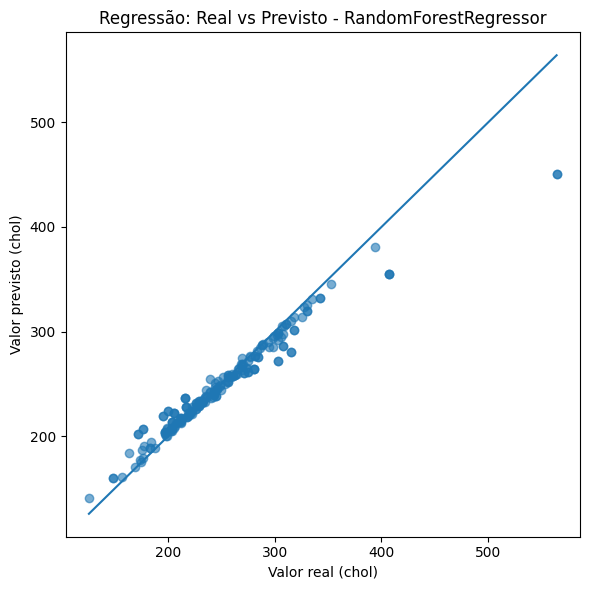

In [33]:
best_reg_row = summary_reg.iloc[0]
best_reg_name = best_reg_row['modelo']
best_reg_entry = next(r for r in results_reg if r['model_name'] == best_reg_name)
best_reg_pipe = best_reg_entry['best_estimator']

print('Melhor modelo (por RMSE-CV):', best_reg_name)
print('Melhores hiperparâmetros:')
display(best_reg_entry['best_params'])

yhat = best_reg_pipe.predict(Xr_test)
mse_test = mean_squared_error(yr_test, yhat)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(yr_test, yhat)

print(f'RMSE (teste) = {rmse_test:.2f}')
print(f'R² (teste)   = {r2_test:.3f}')

plt.figure(figsize=(6, 6))
plt.scatter(yr_test, yhat, alpha=0.6)
plt.xlabel('Valor real (chol)')
plt.ylabel('Valor previsto (chol)')
plt.title(f'Regressão: Real vs Previsto - {best_reg_name}')
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()])
plt.tight_layout()
plt.show()

## 10) BÔNUS: Explicabilidade na Regressão (Permutation Importance)

Além de avaliar o desempenho do melhor regressor no teste, é útil entender
**quais variáveis mais influenciam as previsões**.

Nesta etapa usamos **Permutation Importance**, uma técnica de explicabilidade
agnóstica ao modelo (funciona com regressão linear, árvores, ensembles etc.).

### Como o método funciona
A ideia é medir o impacto de cada feature na performance do modelo:
- Embaralhamos os valores de uma feature (quebrando sua relação com o alvo)
- Recalculamos a métrica no conjunto de teste
- Observamos o quanto a métrica piora

Como estamos em regressão, usamos **R²** como métrica:
- Se embaralhar uma feature causa uma grande queda no **R²**, então ela é importante
- Se a queda for próxima de zero, a feature contribui pouco para o modelo

### Por que usar o conjunto de teste?
Ao calcular a importância no **teste**, obtemos uma medida mais honesta do impacto
das variáveis em dados não vistos, reduzindo o risco de interpretações otimistas.

### Observação importante sobre os nomes das features
Como o pipeline contém **One-Hot Encoding**, o conjunto final de features não é
idêntico às colunas originais:
- Uma variável categórica pode virar várias colunas binárias
- Por isso usamos `get_feature_names_out()` para obter os nomes das features
  **após o pré-processamento**

### Resultado
Por fim, exibimos e plotamos as **Top 15 features** com maior queda média no R²,
facilitando a interpretação e discussão do que o modelo está usando para prever.


num__age         0.553415
num__thalach     0.480636
num__sex         0.396603
num__trestbps    0.232606
num__oldpeak     0.151399
num__restecg     0.097657
num__ca          0.071448
num__thal        0.062741
num__cp          0.056307
num__slope       0.034783
num__exang       0.009705
num__fbs         0.006232
dtype: float64

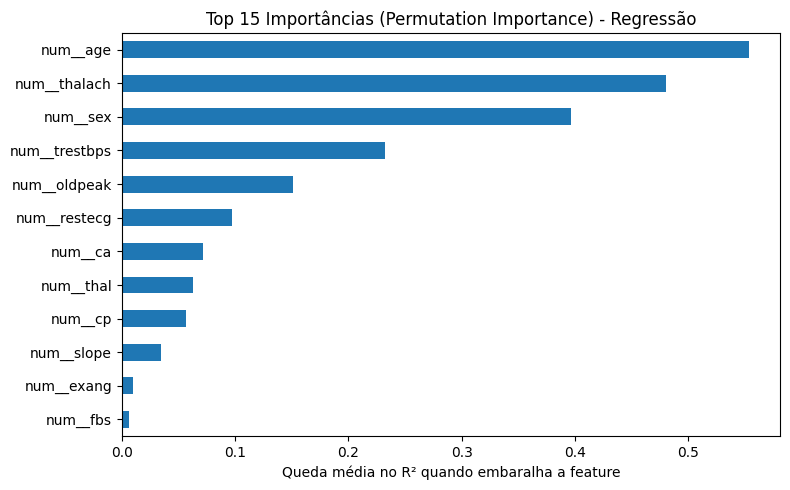

In [35]:
best_reg_pipe.fit(Xr_train, yr_train)
perm_reg = permutation_importance(
    best_reg_pipe,
    Xr_test,
    yr_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring='r2'
)

feature_names_reg = best_reg_pipe.named_steps['preprocess'].get_feature_names_out()
importances_reg = pd.Series(perm_reg.importances_mean, index=feature_names_reg).sort_values(ascending=False)

display(importances_reg.head(15))

plt.figure(figsize=(8, 5))
importances_reg.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Importâncias (Permutation Importance) - Regressão')
plt.xlabel('Queda média no R² quando embaralha a feature')
plt.tight_layout()
plt.show()

# Checklist do enunciado
### Classificação
- [x] ≥ 5 modelos
- [x] Teste de hiperparâmetros em cada modelo (GridSearchCV)
- [x] Validação cruzada (StratifiedKFold 5-fold)
- [x] Métricas: matriz de confusão, acurácia, precisão, recall, F1
- [x] Pipeline com tratamento de dados (imputação + escala)
- [x] Atenção a desbalanceamento (uso de F1 e opção de class_weight)
- [x] Indicação do modelo mais promissor e hiperparâmetros (impressos)

### Regressão
- [x] ≥ 3 modelos
- [x] Teste de hiperparâmetros
- [x] Validação cruzada
- [x] Métricas: R² e RMSE
- [x] Pipeline com imputação + escala

### Bônus
- [x] Explicabilidade via permutation importance (classificação e regressão)